In [1]:
%run import.py

# Feature Interactions #

Now that we know how to encode categorical data, the next thing we want to look at is how to represent our features and work with feature interactions. The first thing we will look at is the difference between tree based models and linear models and how  representing features in a different way can help us get similar results.

## Binning a Descritization with Linear models and Trees ##

To start to understand how to represent our features when using trees and linear models  we will first look at their preformance on a 1-dimensionl synthetic wave dataset.


In [2]:
def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

Now that we have  defined a function that makes a synthetic wave we can get the features and ouputs and plot the data:

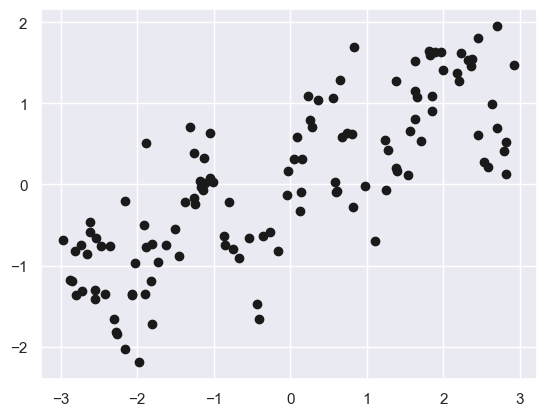

In [3]:
X,y=make_wave(n_samples=120)
plt.plot(X[:, 0], y, 'o', c='k')

Now we can compare the how linear regression and a decision tree would try to fit this data:

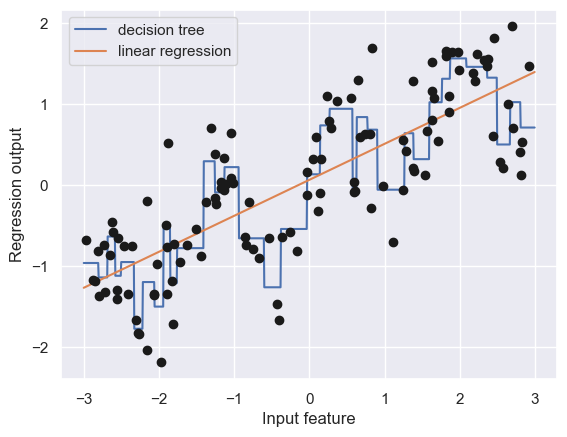

In [4]:
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")
reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

As we can see the linear regression created a best fit line while the decision tree was able to create a more complex model. Although this seems pretty straigth forward we can actually have a linear model generate just as complex of a model if we represent the data in a slightly different way. One way to make this representation is to use *binning* of the feture to split it up into multiple features. We can imagine partitioning the feature into a fixed number of bins, say 10. each data point will be represented based on which bin it fallsd into. We can define the the edges of these bins in a couple of ways, uniform width or using quantiles. Both of these strategies can be implementes in KBinsDiscretizer method. Lets look how it works on the wave dataset we created:

In [8]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=10, strategy='uniform') 
kb.fit(X)
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
        -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
         2.92132162])                                                   ]


Here we can see that the first bin will contain all points that are between -2.9668673 and -2.37804841, the second bin contains all points between -2.37804841 and -1.78922951, and so on. KBinsDescritizer can be applied to multiple features at the same time with bin_edges- containing the edges per feature.

Having created the binning we now want to transfrom the dataset according to the binning. We can do this using the transform method of KBinDesritizer. This mehtod by default uses one-hot-encoding and produces a sparse matrix. Lets create the new features and compare the first ten features of the original data set with the binned dataset:

In [9]:
X_binned = kb.transform(X)
print(X[:10]) 
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

What we did here was turn a continous input feature into a one-hot-encoded categorical features that encodes the bin a data-point is in. instead of the ouput in a sparse matrix we can get the full matrix by using encode='onehot-dense':

In [10]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)
print(X[:10]) 
X_binned[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

Now we can build a new linear regression model and decision tree on the one-hot-encoded data and see how they compare:

Text(0.5, 0, 'Input feature')

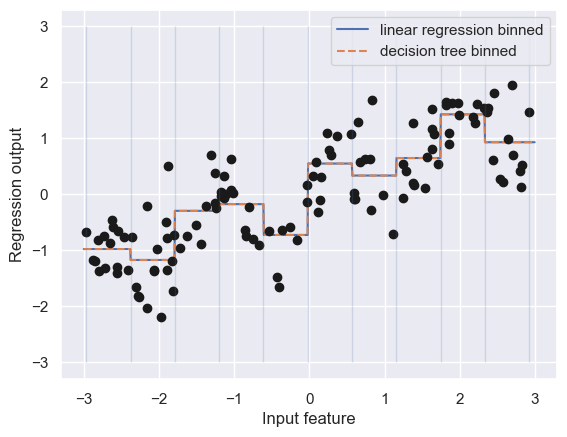

Bad pipe message: %s [b'\r\x1dC\xe2\x1dA\xd2\xfa"\xfd\x99\xcf\x0f\r\x89\x1f\xaf\x0f\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00', b"\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\

In [11]:
line_binned = kb.transform(line)
reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')
reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned',linestyle='dashed')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")


Here we can see that both models produce the exact same predictions. This means that the linear model was able to become more flexible with binnig while the decision tree got much less flexible. Binning features usually has no benficial effect for tree based model because tree models can learn whatever binning is necessary for predicting the data. aditionally tree based models look at multiple features at once whil binning is done in a feature by feature basis. However linear models can benifit greatley using this kind of transformation. We can consider binning as a niave way to transform a linear model into a tree based model. If you need to use a linear model due to high dimensionality binning can be a great way to increase model accuracy.

## Interactions and Polynomials ##

The next type of data enrichment we are going to focus on is interactions between features and using polynomial features. As we saw above our linear model learned a constant value when we binned the data. what if we wanted it to nlearn a slope as well? to do this we could include the original feature back in. this will lead to an 11 dimensional dataset. we can then plot this model with our dataset to see what predictions it makes.

In [9]:
X_combined = np.hstack([X, X_binned]) 
print(X_combined.shape)

(120, 11)


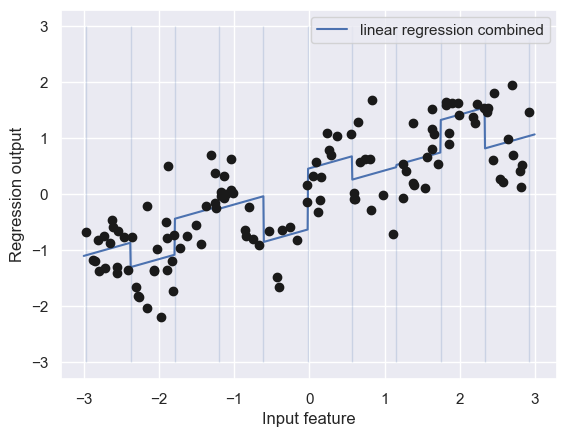

In [10]:
reg = LinearRegression().fit(X_combined, y)
line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

Here our model not only learned the offset for each bin but it learned a slope. Notice that each bin has the same positive slope. This is veacuse we introduced a single feature that has a single slope. To improve this we might want each bin to have its own slope. We can achieve this by adding an interaction between our features. The interaction that makes sense would be the produce. THis will give us an indication of which bin each point belongs to as well as it location on the x-axis. this feature will be the product of the original feature and the binned features. We can create this data and model it as follows:

In [11]:
X_product = np.hstack([X_binned, X * X_binned]) 
print(X_product.shape)

(120, 20)


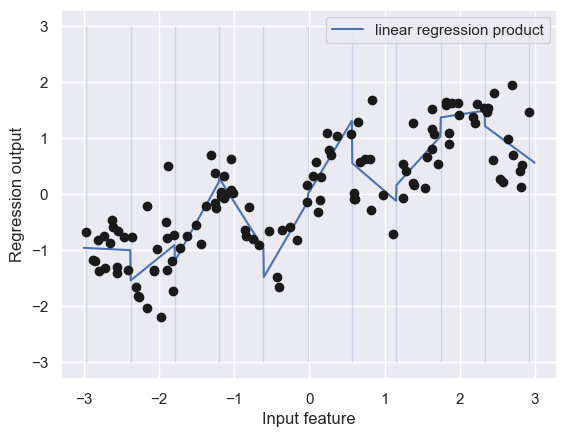

In [12]:
reg = LinearRegression().fit(X_product, y)
line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

We can see that by adding the interaction between the binned values and the original values we were able tolearn an offset for each bin as well as a differnt slope. We were able to use binning to expand what the linear model could learn from a conrinous feature. 

What Could be another way that we could represent the data to smooth out this curve?













One way we can expand the versitility of linear models is by expanding the features into polynomials. This will increse the number of features but will allow us to generate a smoother model. We can generate this using the PolynomialFeatures function in the preprocessing module of sklearn:

In [25]:
from sklearn.preprocessing import PolynomialFeatures
# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1 
poly = PolynomialFeatures(degree=10, include_bias=False) 
poly.fit(X)
X_poly = poly.transform(X)
print("X_poly.shape: {}".format(X_poly.shape))

X_poly.shape: (120, 10)


Here we can see that this created 10 features, lets see how this compares to the original single feature by looking at the first 5 rows:

In [26]:
print("Entries of X:\n{}".format(X[:5])) 
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


How do you think we might be able to generate this same array without using the preprocessing module?

In [33]:
x_poly=np.append(X,X**2,1)

for i in np.arange(3,11):
    x_poly=np.append(x_poly,X**i,1)

print("Entries of X:\n{}".format(X[:5])) 
print("Entries of x_poly:\n{}".format(x_poly[:5]))

print("difference of X_poly and x_poly: \n{}".format((np.abs(X_poly[:5]-x_poly[:5]))))


Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of x_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]
difference of X_poly and x_poly: 
[[0.00000000e+00 0.00

Now by using these these polynomila features along with a linear regression model we can genearte the classical polynomial regression model:

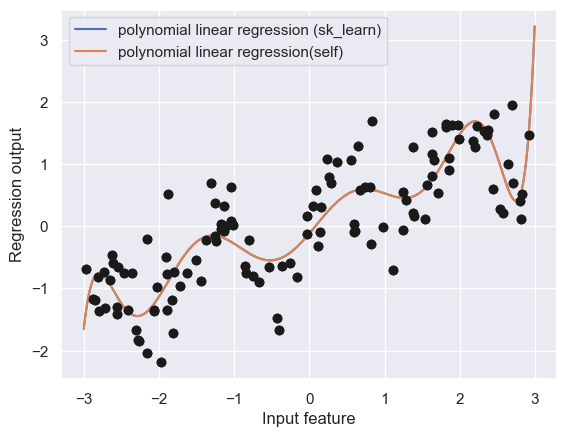

In [34]:
reg1 = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg1.predict(line_poly), label='polynomial linear regression (sk_learn)')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")


reg2 = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg2.predict(line_poly), label='polynomial linear regression(self)')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")


on this one dimensional datset we can see that the model learned a smooth curve to predict from. We also can see that near the edges it begins to behave in extreme ways. This also can occur where ther is little data.

As a comparison lets look at. a more complex model on the originbal dataset and see how it compares to this polynomial model. We will use a support vector model with 2 different values of gamma:

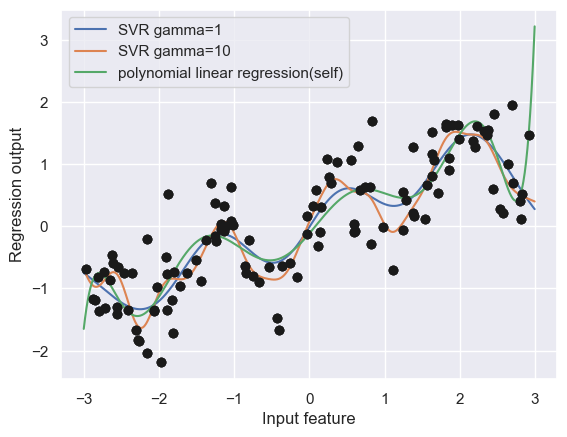

In [35]:

from sklearn.svm import SVR
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))
    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel("Regression output")
    plt.xlabel("Input feature")
    plt.legend(loc="best")
reg2 = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg2.predict(line_poly), label='polynomial linear regression(self)')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

We can see that a linear model with polynomial features can learn similary complex predictions as a SVM model. In the case of the linear model the features can esily be explained as compared to the SVM model.

### Housing data set Example ###

Now lets turn our attention to a realistic application of polynomial features and this time we will include interactions. Here we will look at a housing dataset where we first scale the features:

In [134]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, random_state=12)
# rescale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We will now extract polynomial features up to degree 2:

In [135]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled) 
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled) 
print("X_train.shape: {}".format(X_train.shape)) 
print("X_train_poly.shape: {}".format(X_train_poly.shape))
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

X_train.shape: (15480, 8)
X_train_poly.shape: (15480, 45)
Polynomial feature names:
['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x0^2' 'x0 x1' 'x0 x2'
 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4'
 'x1 x5' 'x1 x6' 'x1 x7' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7'
 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7'
 'x5^2' 'x5 x6' 'x5 x7' 'x6^2' 'x6 x7' 'x7^2']


Here we can see that we went from 8 features to 45 features. By looking at get_feature_names_out we see that we have all first and second order interaction terms. Now lets use these features to develop a linear regression model using ridge regression:

In [136]:
from sklearn.linear_model import Ridge
ridge_scale = Ridge().fit(X_train_scaled, y_train) 
print("Score without interactions (Ridge): {:.3f}".format(ridge_scale.score(X_test_scaled, y_test)))
ridge_poly = Ridge().fit(X_train_poly, y_train) 
print("Score with interactions (Ridge): {:.3f}".format(ridge_poly.score(X_test_poly, y_test)))

reg_scale = LinearRegression().fit(X_train_scaled, y_train) 
print("Score without interactions (Reg): {:.3f}".format(reg_scale.score(X_test_scaled, y_test)))
reg_poly = LinearRegression().fit(X_train_poly, y_train) 
print("Score with interactions (Reg): {:.3f}".format(reg_poly.score(X_test_poly, y_test)))

Score without interactions (Ridge): 0.598
Score with interactions (Ridge): 0.624
Score without interactions (Reg): 0.606
Score with interactions (Reg): 0.678


In [137]:
from sklearn.tree import DecisionTreeRegressor
Dt_scale = DecisionTreeRegressor(max_depth=10).fit(X_train, y_train) 
print("Score without interactions: {:.3f}".format(Dt_scale.score(X_test, y_test)))
Dt_poly = DecisionTreeRegressor(max_depth=10).fit(X_train_poly, y_train) 
print("Score with interactions: {:.3f}".format(Dt_poly.score(X_test_poly, y_test)))


Score without interactions: 0.703
Score with interactions: 0.718


Bad pipe message: %s [b'j\xde\xc9\x07\xfem"\xc0\x91k\'Z\'u=\xb7;\xf7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009']
Bad pipe message: %s [b'\xbe&\xc6C,[e\x8aWV\x1f\x80\xa9\x06W\xd6\xd7\x18\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00']
Bad pipe message: %s [b'\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18']
Bad pipe message: %s [b'\xcf\x82\xb0\x8f\xf5o\xce\xa8\x9f\r#n\xda\x13=\x01\xe6\x94\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\